In [1]:
import numpy as np
from datascience import *


# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots

# This is if you want your plots to have the FiveThirtyEight style
plots.style.use('fivethirtyeight')

# Ghosts and Income

Suppose we want to know whether there is any difference between believing in ghosts and income. We can use a hypothesis test to determine whether there is a real difference between the income of the two groups of people (people who believe in ghosts and people who do not believe in ghosts).

Let's starting by stating the hypotheses. 

**Null hypothesis:** There is no difference in mean income between people who believe in ghosts and people who do not believe in ghosts. 

**Alternative hypothesis:** There is a difference in mean income between people who believe in ghosts and people who do not believe in ghosts. 

In [2]:
cah = Table.read_table('201709-CAH_PulseOfTheNation.csv')

In [3]:
cah.show(5)

Income,Gender,Age,Age Range,Political Affiliation,Do you approve or disapprove of how Donald Trump is handling his job as president?,What is your highest level of education?,What is your race?,What is your marital status?,What would you say is the likelihood that your current job will be entirely performed by robots or computers within the next decade?,"Do you believe that climate change is real and caused by people, real but not caused by people, or not real at all?",How many Transformers movies have you seen?,Do you agree or disagree with the following statement: scientists are generally honest and are serving the public good.,Do you agree or disagree with the following statement: vaccines are safe and protect children from disease.,"How many books, if any, have you read in the past year?",Do you believe in ghosts?,What percentage of the federal budget would you estimate is spent on scientific research?,"Is federal funding of scientific research too high, too low, or about right?",True or false: the earth is always farther away from the sun in the winter than in the summer.,"If you had to choose: would you rather be smart and sad, or dumb and happy?",Do you think it is acceptable or unacceptable to urinate in the shower?
68000,Female,56,55-64,Democrat,Strongly disapprove,High school,Black,Single,Unlikely,DK/REF,0,Somewhat Agree,Somewhat Disagree,6,No,90,Too High,FALSE,Smart and Sad,Unacceptable
46000,Male,63,55-64,Independent,Somewhat Approve,Some college,White,Married,Unlikely,Real but not Caused by People,0,Somewhat Agree,Strongly Agree,0,No,20,About Right,TRUE,Dumb and happy,Acceptable
51000,Male,48,45-54,Republican,Strongly Approve,High school,White,Divorced,Unlikely,Not Real At All,0,Somewhat Disagree,Somewhat Disagree,1,No,10,About Right,FALSE,Dumb and happy,Unacceptable
54000,Female,64,55-64,Democrat,Strongly disapprove,Some college,White,Married,DK/REF,Real and Caused by People,0,Strongly Agree,Strongly Agree,15,No,1,Too Low,TRUE,Smart and Sad,Unacceptable
83000,Male,61,55-64,Independent,Somewhat Approve,College degree,White,Divorced,Unlikely,Real but not Caused by People,0,Strongly Agree,Strongly Agree,0,Yes,10,About Right,TRUE,Dumb and happy,Unacceptable


First, we select the columns we are interested in, and change the column name for the ghosts question to make it easier to use.

In [8]:
ghost_income = cah.select('Income', 'Do you believe in ghosts?').relabeled('Do you believe in ghosts?', 'ghosts')

In [9]:
ghost_income.show(5)

Income,ghosts
68000,No
46000,No
51000,No
54000,No
83000,Yes


## Calculating a test statistic

We want to find whether there is a difference between the mean incomes between the two groups. Let's calculate what the actual mean difference was. We can group by the ghosts question, then find the mean within each. 

In [15]:
mean_income_by_ghost = ghost_income.group('ghosts', collect = np.mean)
mean_income_by_ghost

ghosts,Income mean
DK/REF,175875
No,92566.8
Yes,97130.4


The test statistic can be found by using the absolute difference between the two groups. Note that if we had wanted to know whether one group was greater than the other, we would not use absolute difference, but simply a difference. 

In [18]:
abs(mean_income_by_ghost.column('Income mean').item(1) - mean_income_by_ghost.column('Income mean').item(2))

4563.589862822599

This is what we actually observed. Let's put this inside a function. It should take in a table with the `Income` and `ghosts` columns and output the absolute difference in means between the two groups.  

In [35]:
def statistic(data_table):
    '''
    Calculates the test statistic. Finds the absolute difference in mean Income between ghost groups. 
    '''
    mean_income_by_ghost = data_table.group('ghosts', collect = np.mean)
    return abs(mean_income_by_ghost.column('Income mean').item(1) - mean_income_by_ghost.column('Income mean').item(2))
observed_statistic = statistic(ghost_income)
observed_statistic

4563.589862822599

However, we need to find out what we would have expected to observe if our null hypothesis is true. To do this, we can use simulations. Let's try one simulation first. We need to shuffle the `ghosts` column to make sure it is unrelated to the `Income`, then calculate the difference in mean incomes. We put all of this into a table with `Income` the same as the original and `ghosts` shuffled. 

In [28]:
shuffled_ghosts = ghost_income.sample(ghost_income.num_rows, with_replacement = False).column('ghosts')
simulated_ghost_income = Table().with_columns("Income", ghost_income.column('Income'),
                                              "ghosts", shuffled_ghosts)

In [29]:
statistic(simulated_ghost_income)

10765.728900255752

We can put this inside a function that takes in a Table and just shuffles the `ghosts` column.

In [30]:
def shuffle_ghosts(ghost_income_table):
    '''
    Shuffles the ghost column, then returns a Table with Income and ghosts.
    '''
    shuffled_ghosts = ghost_income_table.sample(ghost_income_table.num_rows, with_replacement = False).column('ghosts')
    simulated_ghost_income = Table().with_columns("Income", ghost_income_table.column('Income'),
                                                  "ghosts", shuffled_ghosts)
    return simulated_ghost_income

Now, let's do it many times. We put this inside a `for` loop. We'll run the simulation 1000 times, shuffling the ghosts column, then calculating the absolute difference in means. We'll store the absolute difference in means inside an array called `differences`.

In [31]:
nsimulations = 1000
differences = make_array()

for i in np.arange(nsimulations):
    simulated_ghost_income = shuffle_ghosts(ghost_income)
    differences = np.append(differences, statistic(simulated_ghost_income))

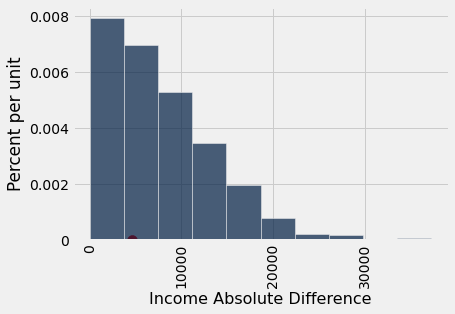

In [39]:
Table().with_column('Income Absolute Difference', differences).hist()
plots.scatter(observed_statistic, 0, color='red', s = 100)

We can also calculate the p-value. 

In [40]:
np.count_nonzero(differences >= observed_statistic) / nsimulations


0.642